# Activity recognition with the Capture24 dataset
This tutorial shows how to create an activity recognition model using the
[Capture-24
dataset](https://ora.ox.ac.uk/objects/uuid:92650814-a209-4607-9fb5-921eab761c11).
If you've ever wanted to know how your Fitbit or Apple Watch recognizes your
daily activities, this tutorial might be a good start.

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn import decomposition
from sklearn import preprocessing
from sklearn import metrics
import features
# For reproducibility
np.random.seed(42)

## Data preparation

In [5]:
print('Content of data/')
dataset_folder = '/home/lixing/har/dataset/capture24'
datas = sorted(os.listdir(dataset_folder))
# Let's load one file
data = pd.read_csv(os.path.join(dataset_folder, datas[0]), index_col='time', parse_dates=['time'],
dtype={'x': 'f4', 'y': 'f4', 'z': 'f4', 'annotation': 'string'})
print("\nParticipant P001:")
print(data)
print("\nUnique annotations")
print(pd.Series(data['annotation'].unique()))

Content of data/

Participant P001:
                                x         y         z              annotation
time                                                                         
2016-11-13 02:18:00.000 -0.466690 -0.533341  0.658472  7030 sleeping;MET 0.95
2016-11-13 02:18:00.010 -0.466690 -0.533341  0.658472  7030 sleeping;MET 0.95
2016-11-13 02:18:00.020 -0.466690 -0.533341  0.658472  7030 sleeping;MET 0.95
2016-11-13 02:18:00.030 -0.466690 -0.533341  0.658472  7030 sleeping;MET 0.95
2016-11-13 02:18:00.040 -0.466690 -0.533341  0.658472  7030 sleeping;MET 0.95
...                           ...       ...       ...                     ...
2016-11-14 06:07:59.960  0.049416 -0.797846  0.565700  7030 sleeping;MET 0.95
2016-11-14 06:07:59.970  0.049416 -0.782285  0.565700  7030 sleeping;MET 0.95
2016-11-14 06:07:59.980  0.049416 -0.782285  0.565700  7030 sleeping;MET 0.95
2016-11-14 06:07:59.990  0.049416 -0.782285  0.565700  7030 sleeping;MET 0.95
2016-11-14 06:08:00.000  0.0

Each row consists of a timestamp, the triaxial acceleration values and an annotation.
The annotation format follows the [Compendium of Physical
Activity](https://sites.google.com/site/compendiumofphysicalactivities/home).
There are more than 100 unique annotations in the whole data.
As you can see, they can be very detailed.
For our purposes, let's simplify the annotations into a reduced set of
activity labels. The file `data/annotation-label-dictionary.csv` was provided
for this:

In [15]:
anno_label_dict = pd.read_csv(os.path.join(dataset_folder, 'annotation-label-dictionary.csv'),
index_col='annotation', dtype='string')
print("Annotation-Label Dictionary")
print(anno_label_dict)

Annotation-Label Dictionary
                                                   label:WillettsSpecific2018  \
annotation                                                                      
7030 sleeping;MET 0.95                                                  sleep   
occupation;office and administrative support;11...                    sitting   
home activity;household chores;preparing meals/...           household-chores   
occupation;office and administrative support;11...                    sitting   
home activity;miscellaneous;sitting;9060 sittin...                    sitting   
...                                                                       ...   
transportation;walking;17250 walking as the sin...             mixed-activity   
transportation;walking;17270 walking as the sin...                    walking   
transportation;public transportation;16016 ridi...                    vehicle   
household-chores;sitstand+lowactivity;MET 2.8                household-chores   


The dictionary provides a number of options to map the detailed
annotations. For example, `label:Willetts2018` summarizes the annotations into
six activity labels: "sleep", "sit-stand", "walking", "vehicle", 'bicycling",
and "mixed". Let's use it to simplify our annotations.

In [8]:
# Create a new "label" column
data['label'] = (anno_label_dict['label:Willetts2018']
.reindex(data['annotation'])
.to_numpy())
print('\nLabel distribution')
print(data['label'].value_counts(normalize=True))


Label distribution
label
sleep        0.367087
sit-stand    0.284237
mixed        0.189988
vehicle      0.080046
walking      0.078642
Name: proportion, dtype: float64


To prepare the actual training data, let's split the data into chunks of 10s.
These will be the inputs to the activity recognition model.
Note: This may take a while

In [9]:
# Extract windows. Make a function as we will need it again later.
def extract_windows(data, winsize='10s'):
    X, Y = [], []
    for t, w in data.resample(winsize, origin='start'):

        # Check window has no NaNs and is of correct length
        # 10s @ 100Hz = 1000 ticks
        if w.isna().any().any() or len(w) != 1000:
            continue

        x = w[['x', 'y', 'z']].to_numpy()
        y = w['label'].mode(dropna=False).item()

        X.append(x)
        Y.append(y)

    X = np.stack(X)
    Y = np.stack(Y)

    return X, Y

In [10]:
print("Extracting windows...")
X, Y = extract_windows(data)

Extracting windows...


## Visualization
Let's plot some instances of each activity

Plotting activities...


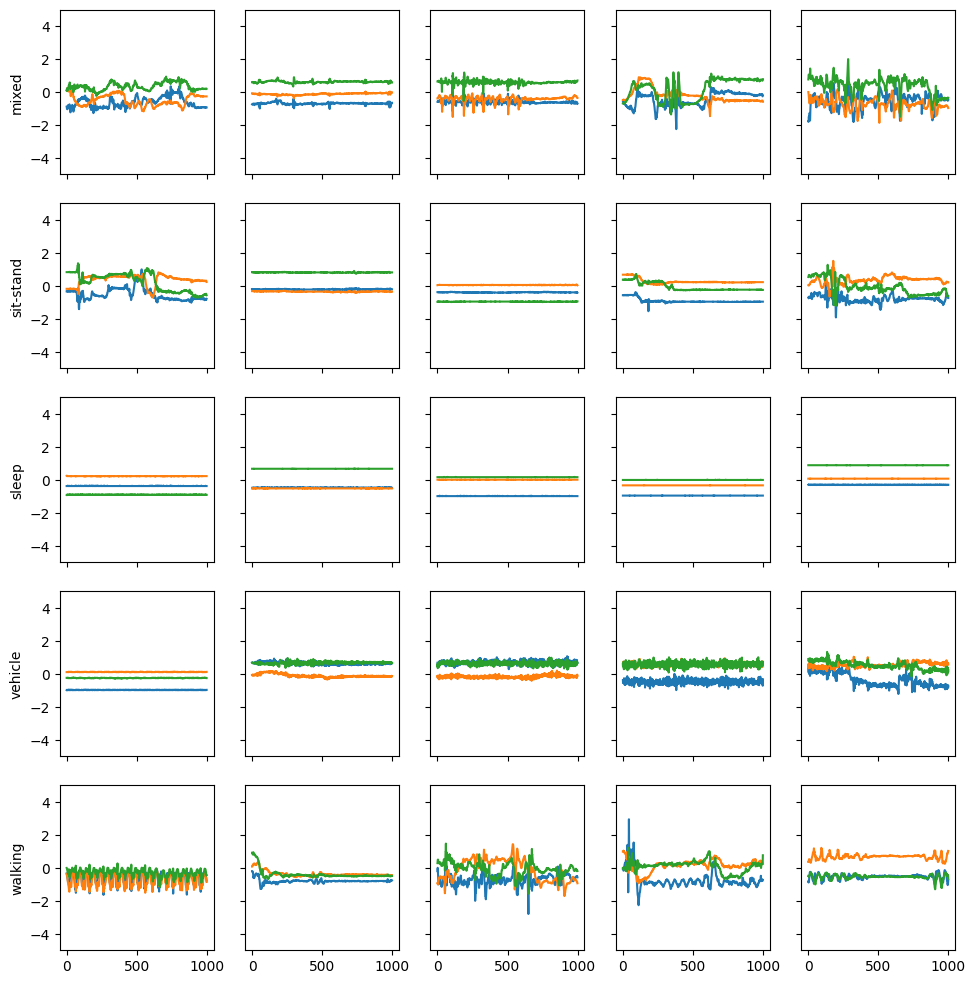

In [11]:
# Plot activities
print("Plotting activities...")
NPLOTS = 5
unqY = np.unique(Y)
fig, axs = plt.subplots(len(unqY), NPLOTS, sharex=True, sharey=True, figsize=(10,10))
for y, row in zip(unqY, axs):
    idxs = np.random.choice(np.where(Y==y)[0], size=NPLOTS)
    row[0].set_ylabel(y)
    for x, ax in zip(X[idxs], row):
        ax.plot(x)
        ax.set_ylim(-5,5)
fig.tight_layout()
fig.show()

Something to note from the plot above is the heterogeneity of the signals even
within the same activities. This is typical of free-living data, as opposed to
clean lab data where subjects perform a scripted set of activities under
supervision.
Now let's perform a PCA plot

Plotting first two PCA components...


<ipython-input-18-def5a1b07243>:16: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


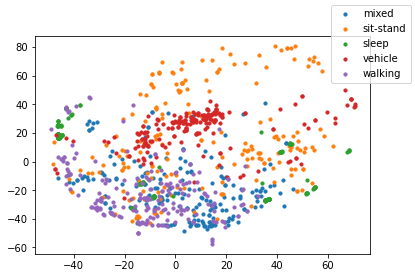

In [18]:
# PCA plot
print("Plotting first two PCA components...")
scaler = preprocessing.StandardScaler()  # PCA requires normalized data
X_scaled = scaler.fit_transform(X.reshape(X.shape[0],-1))
pca = decomposition.PCA(n_components=2)  # two components
X_pca = pca.fit_transform(X_scaled)

NPOINTS = 200
unqY = np.unique(Y)
fig, ax = plt.subplots()
for y in unqY:
    idxs = np.random.choice(np.where(Y==y)[0], size=NPOINTS)
    x = X_pca[idxs]
    ax.scatter(x[:,0], x[:,1], label=y, s=10)
fig.legend()
fig.show()

## Activity recognition
We will use a random forest to build the activity recognition model.
Rather than using the raw signal as the input which is very inefficient,
we use common statistics and features of the signal such as the quantiles,
correlations, dominant frequencies, number of peaks, etc. See `features.py`.
Note: this may take a while

In [12]:
X_feats = pd.DataFrame([features.extract_features(x) for x in X])
print(X_feats)

          xmin      xq25      xmed      xq75      xmax      ymin      yq25  \
0    -0.482334 -0.466690 -0.466690 -0.466690 -0.466690 -0.548902 -0.548902   
1    -0.482334 -0.466690 -0.466690 -0.466690 -0.466690 -0.548902 -0.548902   
2    -0.482334 -0.482334 -0.466690 -0.466690 -0.466690 -0.548902 -0.533341   
3    -0.482398 -0.482334 -0.466690 -0.466690 -0.466690 -0.548902 -0.533341   
4    -0.482398 -0.482334 -0.466690 -0.466690 -0.466626 -0.548902 -0.533341   
...        ...       ...       ...       ...       ...       ...       ...   
7347  0.033708  0.033772  0.049416  0.049416  0.049416 -0.813407 -0.797846   
7348  0.033708  0.033772  0.049416  0.049416  0.065059 -0.813407 -0.797846   
7349  0.033772  0.049416  0.049416  0.049416  0.049416 -0.797846 -0.797846   
7350  0.033708  0.033772  0.049352  0.049416  0.049416 -0.797846 -0.797846   
7351  0.033708  0.033772  0.049416  0.049416  0.049416 -0.797846 -0.797846   

          ymed      yq75      ymax  ...     rollg    pitchg    

Now train the random forest
Note: this may take a while

In [13]:
clf = BalancedRandomForestClassifier(
n_estimators=100,
replacement=True,
sampling_strategy='not minority',
n_jobs=4,
random_state=42,
)
clf.fit(X_feats, Y)
print('\nClassifier self-performance')
print(metrics.classification_report(Y, clf.predict(X_feats), zero_division=0))

/home/lixing/miniconda3/envs/har/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:601: FutureWarning: The default of `bootstrap` will change from `True` to `False` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `False` to silence this warning and adopt the future behaviour.
  warn(



Classifier self-performance
              precision    recall  f1-score   support

       mixed       0.93      0.90      0.91      1383
   sit-stand       0.97      0.88      0.92      2081
       sleep       1.00      0.98      0.99      2742
     vehicle       0.90      0.99      0.94       588
     walking       0.72      1.00      0.84       558

    accuracy                           0.94      7352
   macro avg       0.90      0.95      0.92      7352
weighted avg       0.95      0.94      0.94      7352



The in-sample performance is very good, though of course this is unrealistic as
we're testing on the same data that we trained on. Let's load another person's
data and test on that instead:
Note: this may take a while

In [14]:
# Load another participant data
data2 = pd.read_csv(os.path.join(dataset_folder, datas[1]),
index_col='time', parse_dates=['time'],
dtype={'x': 'f4', 'y': 'f4', 'z': 'f4', 'annotation': 'string'})
# Simplify annotations
data2['label'] = (anno_label_dict['label:Willetts2018']
.reindex(data2['annotation'])
.to_numpy())
# Extract windows
X2, Y2 = extract_windows(data2)
# Extract features
X2_feats = pd.DataFrame([features.extract_features(x) for x in X2])
print('\nClassifier performance on new subject')
print(metrics.classification_report(Y2, clf.predict(X2_feats), zero_division=0))


Classifier performance on new subject
              precision    recall  f1-score   support

   bicycling       0.00      0.00      0.00       230
       mixed       0.33      0.39      0.36       724
   sit-stand       0.75      0.41      0.53      2073
       sleep       0.94      0.86      0.90      2160
     vehicle       0.00      0.00      0.00         0
     walking       0.28      0.50      0.36       399

    accuracy                           0.57      5586
   macro avg       0.38      0.36      0.36      5586
weighted avg       0.71      0.57      0.62      5586



As expected, the model is worse on the new subject. A few things
to note: "bicycling" wasn't present in the first subject, therefore the
model couldn't predict any bicycling activities for the second subject. Also, the
second subject doesn't have any "vehicle" instances, so the scores were set to
zero for this. Finally, classification performance for "sleep" and "sit-stand"
instances remain reasonably good, which is not surprising as the signal variance
is already a good predictor of inactivity.
## Conclusion
In this tutorial, we showed how to use the Capture-24 dataset to train an
activity recognition model. As you can see, the bulk of the work is on preparing
the data for training. To summarize, the steps are:
- Map the annotations to a reduced and manageable number of activities
- Split the data into chunks to create the training instances
- Extract signal features from each chunk
- Train the model
Here we used only one subject's data to build the model, but of course you
will want to use more of the data available. We provided the script
`prepare_data.py` to help you prepare the data in bulk. You should see a
significant improvement with more training data.
## References
Papers that used the Capture-24 dataset:
- [Reallocating time from machine-learned sleep, sedentary behaviour or
light physical activity to moderate-to-vigorous physical activity is
associated with lower cardiovascular disease
risk](https://www.medrxiv.org/content/10.1101/2020.11.10.20227769v2.full?versioned=true)
(Walmsley2020 labels)
- [GWAS identifies 14 loci for device-measured
physical activity and sleep
duration](https://www.nature.com/articles/s41467-018-07743-4)
(Doherty2018 labels)
- [Statistical machine learning of sleep and physical activity phenotypes
from sensor data in 96,220 UK Biobank
participants](https://www.nature.com/articles/s41598-018-26174-1)
(Willetts2018 labels)